1. Importar Librerías

In [27]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#plt.style.use("seaborn-v0_8-darkgrid")

2. Abrir archivo ROOT y leer árbol

In [28]:
file = uproot.open("NeutronData_24.0x30.0x9.0.root")
tree = file["NeutronTracks"]

print(tree.keys())

['EventID', 'TrackID', 'ParentID', 'KineticEnergy_eV', 'FinalTime_ns', 'FinalPosX_mm', 'FinalPosY_mm', 'FinalPosZ_mm', 'TotalTrackLength_mm', 'NumSteps', 'FinalVolume', 'FinalProcess', 'DirX', 'DirY', 'DirZ']


3. Cargar datos a un DataFrame

In [29]:
data = tree.arrays(library="pd")
data.head()

,EventID,TrackID,ParentID,KineticEnergy_eV,FinalTime_ns,FinalPosX_mm,FinalPosY_mm,FinalPosZ_mm,TotalTrackLength_mm,NumSteps,FinalVolume,FinalProcess,DirX,DirY,DirZ
0,7,1,0,4.200000e+06,3.256441,0.000000,0.000000,46.0,93.000000,4,Detector,Transportation,0.000000,0.000000,1.00000
1,14,1,0,4.200000e+06,3.256441,0.000000,0.000000,46.0,93.000000,4,Detector,Transportation,0.000000,0.000000,1.00000
2,21,1,0,4.200000e+06,3.256441,0.000000,0.000000,46.0,93.000000,4,Detector,Transportation,0.000000,0.000000,1.00000
3,26,1,0,4.125769e+06,3.270080,-0.954878,1.161883,46.0,93.473778,5,Detector,Transportation,-0.284249,0.345871,0.89419
4,32,1,0,4.200000e+06,3.256441,0.000000,0.000000,46.0,93.000000,4,Detector,Transportation,0.000000,0.000000,1.00000


4. Descripción básica

In [30]:
print("Eventos:", len(data))
data.describe()

Eventos: 1921


,EventID,TrackID,ParentID,KineticEnergy_eV,FinalTime_ns,FinalPosX_mm,FinalPosY_mm,FinalPosZ_mm,TotalTrackLength_mm,NumSteps,DirX,DirY,DirZ
count,1921.000000,1921.0,1921.0,1.921000e+03,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000
mean,4963.343050,1.0,0.0,3.675980e+06,1867.962136,0.072432,-0.067616,46.002093,100.204690,5.666320,0.000816,-0.004530,0.945642
std,2934.246019,0.0,0.0,1.170386e+06,17115.594729,2.860528,2.886927,0.039556,45.263904,8.437241,0.217904,0.201785,0.132649
min,7.000000,1.0,0.0,5.462653e-04,3.256441,-10.000000,-9.941763,46.000000,93.000000,4.000000,-0.946951,-0.959990,0.080270
25%,2389.000000,1.0,0.0,4.110699e+06,3.256441,0.000000,0.000000,46.000000,93.000000,4.000000,0.000000,0.000000,0.977768
50%,4977.000000,1.0,0.0,4.200000e+06,3.256441,0.000000,0.000000,46.000000,93.000000,4.000000,0.000000,0.000000,1.000000
75%,7488.000000,1.0,0.0,4.200000e+06,3.291511,0.000000,0.000000,46.000000,93.658972,5.000000,0.000000,0.000000,1.000000
max,9994.000000,1.0,0.0,4.200000e+06,323222.122594,10.000000,10.000000,46.947218,877.555904,131.000000,0.973904,0.966705,1.000000


5. Histograma log-log de energías finales

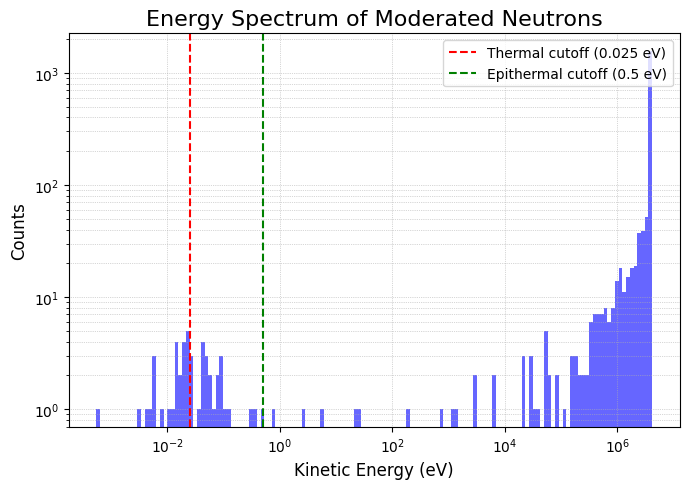

In [31]:
E_TERMICO_MAX_EV = 0.025
E_EPITERMICO_MAX_EV = 0.5


# --- ENERGY SPECTRUM (Log-Log) ---
ener = data["KineticEnergy_eV"]

plt.figure(figsize=(7, 5))

# Filtrar energías > 0 para evitar problemas con log(0)
energias_positivas = ener[ener > 0]

if not energias_positivas.empty:

    # Determinar límites logarítmicos
    e_min = max(1e-5, energias_positivas.min())
    e_max = energias_positivas.max()

    if e_min < e_max:
        bins_log = np.logspace(np.log10(e_min), np.log10(e_max), 150)
    else:
        bins_log = np.array([e_min, e_max])

    # Histograma
    plt.hist(energias_positivas, bins=bins_log, color='blue', alpha=0.6)

# --- Líneas de corte ---
plt.axvline(E_TERMICO_MAX_EV, color='red', linestyle='--',
            label=f'Thermal cutoff ({E_TERMICO_MAX_EV} eV)')

plt.axvline(E_EPITERMICO_MAX_EV, color='green', linestyle='--',
            label=f'Epithermal cutoff ({E_EPITERMICO_MAX_EV} eV)')

# Escalas log-log
plt.xscale('log')
plt.yscale('log')

plt.title('Energy Spectrum of Moderated Neutrons', fontsize=16)
plt.xlabel('Kinetic Energy (eV)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.legend()

plt.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout()

nombre_fig = "Energy_Spectrum.png"

plt.show()


6. Clasificación de energías (térmicos, epitérmicos, rápidos)

In [32]:
# Clasificación por energía
thermal = np.sum(ener < 0.025)
epithermal = np.sum((ener >= 0.025) & (ener < 0.5))
fast = np.sum(ener >= 0.5)

# Total detectados en el archivo
detected = len(ener)

# Total simulados en Geant4
simulated = 10000000

print("=== Conteo de neutrones detectados ===")
print(f"Térmicos (<0.025 eV): {thermal}")
print(f"Epitérmicos (0.025–0.5 eV): {epithermal}")
print(f"Rápidos (>0.5 eV): {fast}")
print(f"Total detectados: {detected} de {simulated}")

# Porcentajes respecto a detectados
print("\n=== Porcentajes respecto a detectados ===")
print(f"Térmicos: {thermal/detected*100:.2f}%")
print(f"Epitérmicos: {epithermal/detected*100:.2f}%")
print(f"Rápidos: {fast/detected*100:.2f}%")

# Porcentajes respecto al total simulado
print("\n=== Porcentajes respecto a los 10000 neutrones simulados ===")
print(f"Térmicos: {thermal/simulated*100:.3f}%")
print(f"Epitérmicos: {epithermal/simulated*100:.3f}%")
print(f"Rápidos: {fast/simulated*100:.3f}%")

# Eficiencia total de transporte a la región donde mides
print("\n=== Eficiencia total de neutrones que alcanzaron el detector ===")
print(f"Eficiencia = {detected/simulated*100:.3f}%")


=== Conteo de neutrones detectados ===
Térmicos (<0.025 eV): 26
Epitérmicos (0.025–0.5 eV): 22
Rápidos (>0.5 eV): 1873
Total detectados: 1921 de 10000000

=== Porcentajes respecto a detectados ===
Térmicos: 1.35%
Epitérmicos: 1.15%
Rápidos: 97.50%

=== Porcentajes respecto a los 10000 neutrones simulados ===
Térmicos: 0.000%
Epitérmicos: 0.000%
Rápidos: 0.019%

=== Eficiencia total de neutrones que alcanzaron el detector ===
Eficiencia = 0.019%


8. Procesos que detuvieron al neutrón

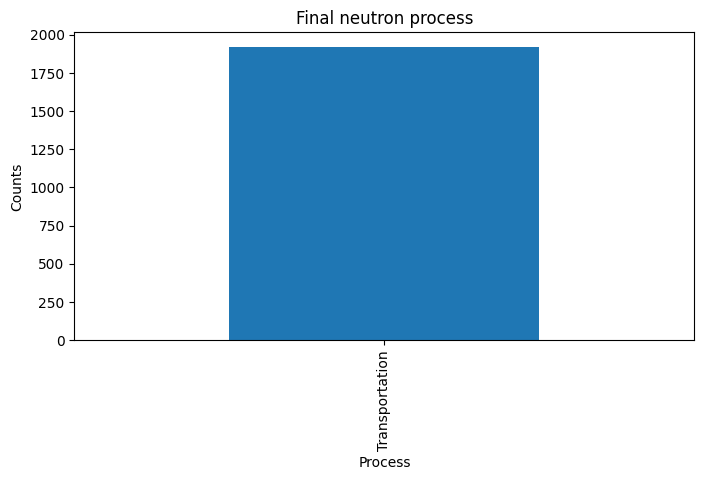

In [33]:
procs = np.array(data["FinalProcess"].to_list())
procs_count = pd.Series(procs).value_counts()

procs_count.plot(kind="bar", figsize=(8,4))
plt.title("Final neutron process")
plt.xlabel("Process")
plt.ylabel("Counts")
plt.show()

Steps vs Energía (scatter)

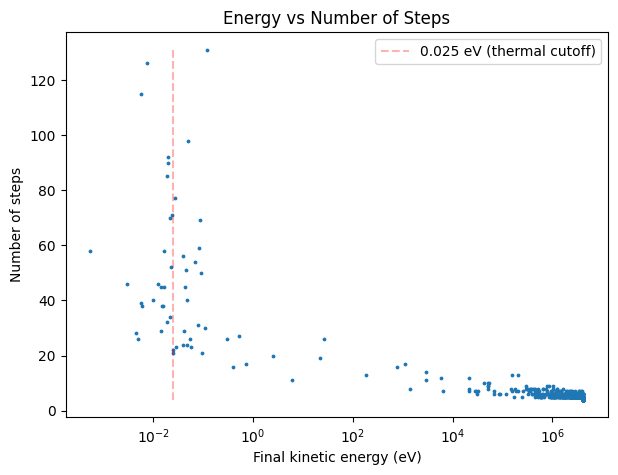

In [34]:
plt.figure(figsize=(7,5))
plt.scatter(data["KineticEnergy_eV"], data["NumSteps"],
            s=3)

plt.vlines(0.025, ymin=data["NumSteps"].min(), ymax=data["NumSteps"].max(),
           colors="red", linestyles="dashed", label="0.025 eV (thermal cutoff)",alpha=0.3)

plt.xscale("log")
plt.xlabel("Final kinetic energy (eV)")
plt.ylabel("Number of steps")
plt.title("Energy vs Number of Steps")
plt.legend()
plt.show()



Histograma Steps

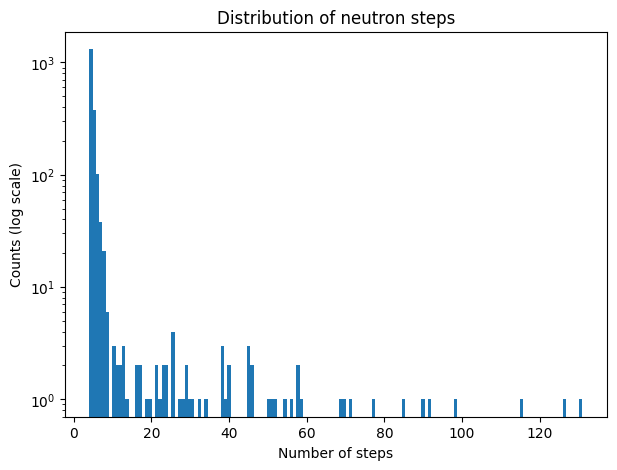

In [35]:
plt.figure(figsize=(7,5))
plt.hist(data["NumSteps"], bins=150, log=True)
plt.xlabel("Number of steps")
plt.ylabel("Counts (log scale)")
plt.title("Distribution of neutron steps")
plt.show()


In [36]:
E_TERMICO_MAX_EV = 0.025
E_EPITERMICO_MAX_EV = 0.5

ener = data["KineticEnergy_eV"]
steps = data["NumSteps"]

# Filtros
thermal = data[ener < E_TERMICO_MAX_EV]
epithermal = data[(ener >= E_TERMICO_MAX_EV) & (ener < E_EPITERMICO_MAX_EV)]


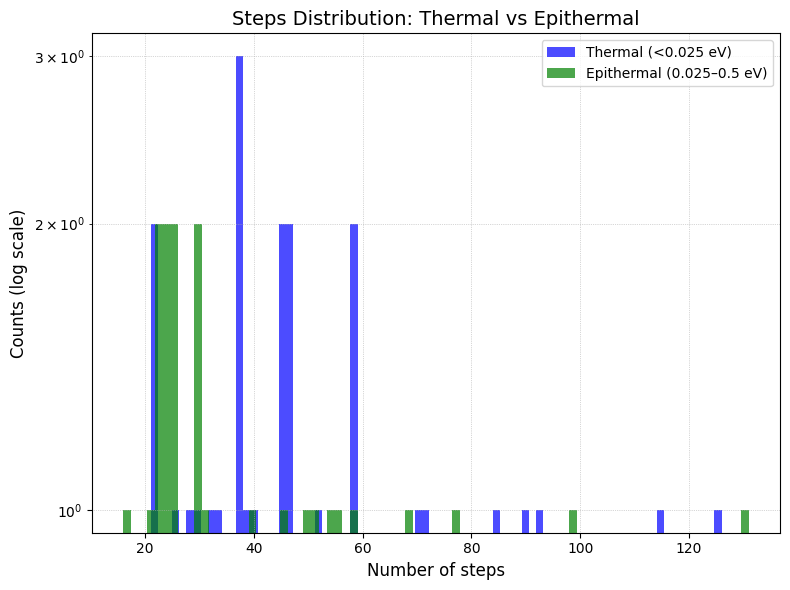

In [37]:
plt.figure(figsize=(8,6))

plt.hist(thermal["NumSteps"], bins=80, alpha=0.7,
         color='blue', label='Thermal (<0.025 eV)')

plt.hist(epithermal["NumSteps"], bins=80, alpha=0.7,
         color='green', label='Epithermal (0.025–0.5 eV)')

plt.yscale("log")
plt.xlabel("Number of steps", fontsize=12)
plt.ylabel("Counts (log scale)", fontsize=12)
plt.title("Steps Distribution: Thermal vs Epithermal", fontsize=14)
plt.grid(True, which="both", linestyle=":", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()



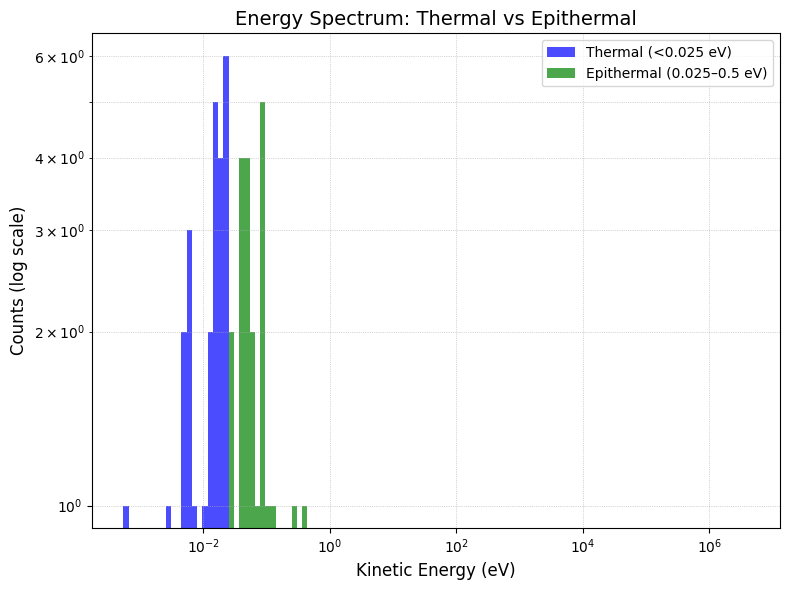

In [38]:
plt.figure(figsize=(8,6))

# Energías positivas (protege de log(0))
epos = ener[ener > 0]
bins_log = np.logspace(np.log10(epos.min()), np.log10(epos.max()), 120)

plt.hist(thermal["KineticEnergy_eV"], bins=bins_log, alpha=0.7,
         color='blue', label='Thermal (<0.025 eV)')

plt.hist(epithermal["KineticEnergy_eV"], bins=bins_log, alpha=0.7,
         color='green', label='Epithermal (0.025–0.5 eV)')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Kinetic Energy (eV)", fontsize=12)
plt.ylabel("Counts (log scale)", fontsize=12)
plt.title("Energy Spectrum: Thermal vs Epithermal", fontsize=14)
plt.grid(True, which="both", linestyle=":", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()
